In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
# Primary Admissions information
df = pd.read_csv(r"MIMIC-IV/admissions.csv")

# Patient specific info such as gender
df_pat = pd.read_csv(r"MIMIC-IV/patients.csv")

# Diagnosis for each admission to hospital
df_diagcode = pd.read_csv(r"MIMIC-IV/diagnoses_icd.csv")

# Intensive Care Unit (ICU) for each admission to hospital
df_icu = pd.read_csv(r"MIMIC-IV/icustays.csv")

In [4]:
print('Dataset has {} number of unique admission events.'.format(df['hadm_id'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['subject_id'].nunique()))

Dataset has 523740 number of unique admission events.
Dataset has 256878 number of unique patients.


In [5]:
# Convert admission and discharge times to datatime type
df['ADMITTIME'] = pd.to_datetime(df['admittime'])
df['DISCHTIME'] = pd.to_datetime(df['dischtime'])

# Calculating the Length of Stay variable using the difference between Discharge time and Admit time 
# Convert timedelta type into float 'days'. Note: There are 86400 seconds in a day
df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds()/86400

In [6]:
df['LOS'].describe()

count    523740.000000
mean          4.563912
std           7.598788
min          -0.979167
25%           1.239583
50%           2.673611
75%           4.962500
max        1191.416667
Name: LOS, dtype: float64

In [7]:
# Drop rows with negative LOS. The negative LOS means that the patient was brought dead to the ICU.
df['LOS'][df['LOS'] > 0].describe()

count    523565.000000
mean          4.565548
std           7.599529
min           0.000694
25%           1.240972
50%           2.674306
75%           4.963194
max        1191.416667
Name: LOS, dtype: float64

In [8]:
# Drop LOS < 0 
df = df[df['LOS'] > 0]

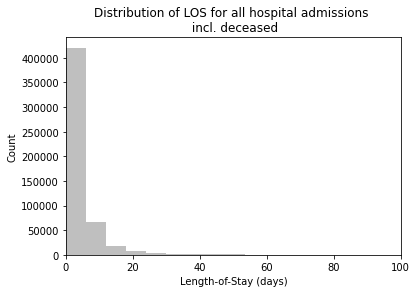

In [9]:
# Plot LOS Distribution
plt.hist(df['LOS'], bins=200, color = '0.75')
plt.xlim(0, 100)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [10]:
# Dropping the columns that are not needed
df.drop(columns=['dischtime','DISCHTIME', 
                'edregtime', 'edouttime', 'hospital_expire_flag'], inplace=True)

In [11]:
# Mapping the dead and alive value of patients who died in hospital as 1 and 0
df['DECEASED'] = df['deathtime'].notnull().map({True:1, False:0})

In [12]:
print("{} of {} patients died in the hospital".format(df['DECEASED'].sum(), 
                                                      df['subject_id'].nunique()))

9240 of 256796 patients died in the hospital


In [13]:
# Descriptive analysis of patients who died during the stay in ICU
df['LOS'].loc[df['DECEASED'] == 0].describe()

count    514325.000000
mean          4.468725
std           7.179970
min           0.000694
25%           1.231944
50%           2.656250
75%           4.905556
max         467.090278
Name: LOS, dtype: float64

In [14]:
# Descriptive analysis of LOS metric (target variable)
mean_los = df['LOS'].mean() 
median_los = df['LOS'].median()
min_los = df['LOS'].min()
max_los = df['LOS'].max()

print("Mean LOS: ",mean_los)
print("Median LOS: ",median_los)
print("Min LOS: ",min_los)
print("Max LOS: ",max_los)

Mean LOS:  4.565548119887482
Median LOS:  2.6743055555555557
Min LOS:  0.0006944444444444446
Max LOS:  1191.4166666666667


In [15]:
df['ethnicity'].unique()

array(['UNKNOWN', 'WHITE', 'OTHER', 'BLACK/AFRICAN AMERICAN', 'ASIAN',
       'HISPANIC/LATINO', 'UNABLE TO OBTAIN',
       'AMERICAN INDIAN/ALASKA NATIVE'], dtype=object)

In [16]:
# Club the Ethnicity categories into 5 broad categories
df['ethnicity'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ethnicity'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ethnicity'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ethnicity'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ethnicity'].replace(['UNABLE TO OBTAIN', 'OTHER',
                         'UNKNOWN'], value='OTHER/UNKNOWN', inplace=True)
df['ethnicity'].loc[~df['ethnicity'].isin(df['ethnicity'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ethnicity'].value_counts()

/home/sylma3/miniconda3/envs/skin/lib/python3.9/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


WHITE                     337533
BLACK/AFRICAN AMERICAN     80270
OTHER/UNKNOWN              51447
HISPANIC/LATINO            29816
ASIAN                      24499
Name: ethnicity, dtype: int64

In [17]:
# Bar plot function
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
    
# Boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['LOS'].loc[df[variable]==cat].values)

    _, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

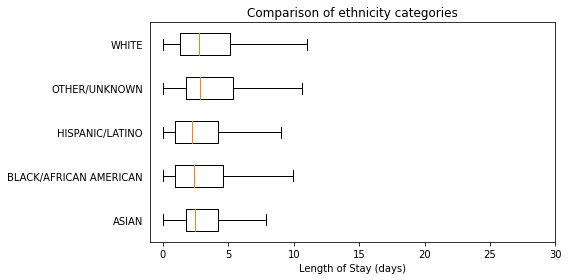

In [18]:
boxplot_los_groupby('ethnicity', los_range=(-1, 30))

In [19]:
df['admission_type'].value_counts()

EW EMER.                       157825
EU OBSERVATION                 100394
ELECTIVE                        72049
OBSERVATION ADMIT               55491
URGENT                          47919
SURGICAL SAME DAY ADMISSION     41071
DIRECT EMER.                    21577
DIRECT OBSERVATION              19985
AMBULATORY OBSERVATION           7254
Name: admission_type, dtype: int64

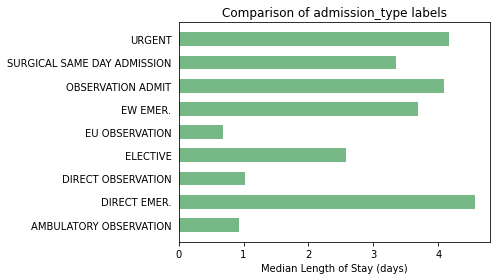

In [20]:
plot_los_groupby('admission_type')

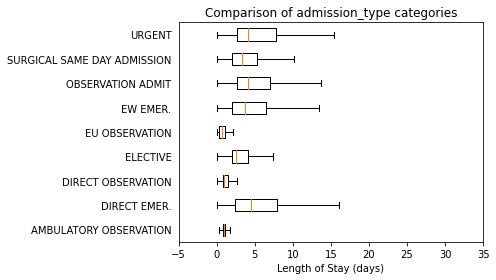

In [21]:
boxplot_los_groupby('admission_type', los_range=(-5, 35), size=(7, 4))

In [22]:
df['insurance'].value_counts()

Other       301427
Medicare    171309
Medicaid     50829
Name: insurance, dtype: int64

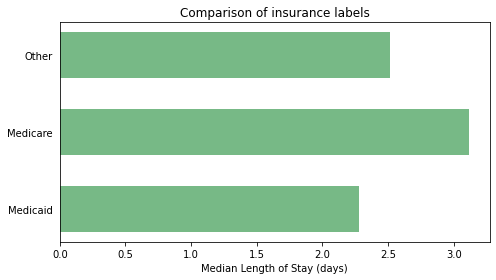

In [23]:
plot_los_groupby('insurance')

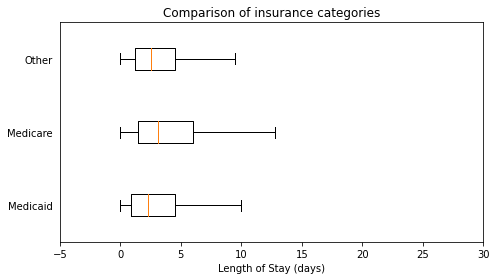

In [24]:
boxplot_los_groupby('insurance', los_range=(-5, 30), size=(7, 4))

In [25]:
df['marital_status'].value_counts(dropna=False)

MARRIED     195074
SINGLE      179935
NaN          66058
WIDOWED      48799
DIVORCED     33699
Name: marital_status, dtype: int64

In [26]:
# Replacing NAs as'UNKNOWN'
df['marital_status'] = df['marital_status'].fillna('UNKNOWN (DEFAULT)')
df['marital_status'].value_counts(dropna=False)

MARRIED              195074
SINGLE               179935
UNKNOWN (DEFAULT)     66058
WIDOWED               48799
DIVORCED              33699
Name: marital_status, dtype: int64

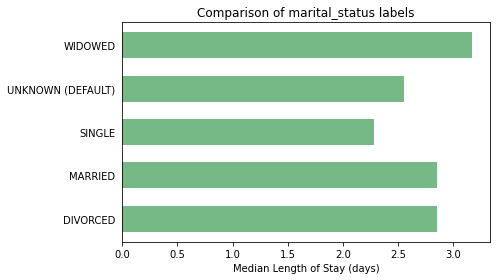

In [27]:
plot_los_groupby('marital_status')

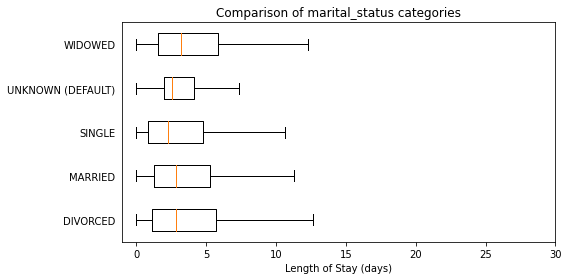

In [28]:
boxplot_los_groupby('marital_status')

**ICD9 coding methodolog: the diagnosis codes are arranged are as follows:**

001–139: infectious and parasitic diseases

140–239: neoplasms

240–279: endocrine, nutritional and metabolic diseases, and immunity disorders

280–289: diseases of the blood and blood-forming organs

290–319: mental disorders

320–389: diseases of the nervous system and sense organs

390–459: diseases of the circulatory system

460–519: diseases of the respiratory system

520–579: diseases of the digestive system

580–629: diseases of the genitourinary system

630–679: complications of pregnancy, childbirth, and the puerperium

680–709: diseases of the skin and subcutaneous tissue

710–739: diseases of the musculoskeletal system and connective tissue

740–759: congenital anomalies

760–779: certain conditions originating in the perinatal period

780–799: symptoms, signs, and ill-defined conditions

800–999: injury and poisoning

E and V codes: external causes of injury and supplemental classification, using 999 as placeholder even though it overlaps with complications of medical care

Source of these categories: https://en.wikipedia.org/wiki/List_of_ICD-9_codes

In [29]:
df_diagcode.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,15734973,20475282,3,2825,9
1,15734973,20475282,2,V0251,9
2,15734973,20475282,5,V270,9
3,15734973,20475282,1,64891,9
4,15734973,20475282,4,66481,9


In [30]:
print(df_diagcode['icd_code'].unique(), len(df_diagcode['icd_code'].unique()))

['2825' 'V0251' 'V270' ... 'T6101XA' 'S92502A' 'Z13220'] 27170


In [31]:
print(df_diagcode['icd_version'].unique(), len(df_diagcode['icd_version'].unique()))

[ 9 10] 2


In [32]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['icd_code'][df_diagcode['icd_version'] == 9]
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)

In [33]:
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

In [34]:
print(df_diagcode['recode'].unique(), len(df_diagcode['recode'].unique()))

[282 999 648 664 659 642 645 784 652 646 656 756 663 647  54 724 658 666
 661 340 654 655 746 665 218 564 644 660 653 668 349 599 244 354 496 530
 568 401 625 620 780 346 626 792 651 641 242 669 245 614  41 287 650 682
 782 295 596 788 220 671 649 289 701 278 327 272 789 309 315 285 672 389
 493 311 698 280 674 673 576 300 616 795 615 670 624 252 227 600 250 362
 528 579 733 556 575 585 535 331 532 403 583 781 458 296 577 783 294   8
 372 112 437 584 427 486 618 276 722 356 715 518 718 736 477 939 344 690
 271 592 553 221 305 332 193 721 998 555 716 117 567 274 153 569 414 413
 286 997 562 453 415 623 369 462 288 438 515 345 617 591 557 574 226  42
 492 240 185 197 560 198 441 440 425 292 424 428 657 552 412 150 196 151
 996 426 396 397 571 266 338 241 802 852 719 465 511 482 514  70 607 787
 521 707 459 253  38 157 211 573 790 995 263 742 123 333 202 565 517 135
 466 304 611 785 235 593 433 314 473  78 735 443 239 695 293 867 918 416
 277 512 203 753 726 357 713 351 729 727 905 728 74

In [35]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]), 
            num, df_diagcode['recode'])
    
# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

In [36]:
# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('hadm_id')['cat'].apply(list).reset_index()

In [37]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)

In [38]:
# Join the above created dataset using hadm_id to the hadm_list
hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")

In [39]:
# Finally merging with main admissions df
df = df.merge(hadm_item, how='inner', on='hadm_id')

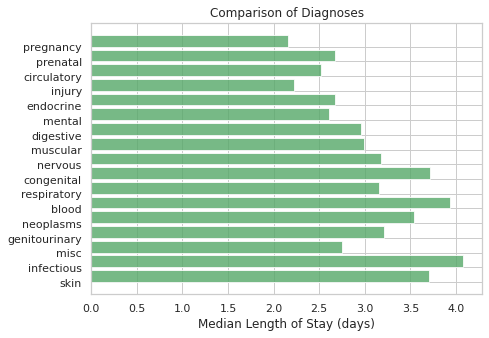

In [40]:
# Explore median LOS by diagnosis category as defined above
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                 'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(df[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

In [41]:
df_icu['hadm_id'].nunique()

69211

In [42]:
df_icu.keys()

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los'],
      dtype='object')

In [43]:
df_icu['first_careunit'].unique()

array(['Trauma SICU (TSICU)', 'Neuro Stepdown',
       'Coronary Care Unit (CCU)', 'Neuro Intermediate',
       'Medical Intensive Care Unit (MICU)',
       'Cardiac Vascular Intensive Care Unit (CVICU)',
       'Surgical Intensive Care Unit (SICU)',
       'Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'Medical/Surgical Intensive Care Unit (MICU/SICU)'], dtype=object)

In [44]:
# Converting different categories of first care unit into ICU and NICU groups
df_icu['first_careunit'].replace({'Coronary Care Unit (CCU)': 'ICU',
                                  'Neuro Stepdown': 'NICU',
                                  'Neuro Intermediate': 'NICU',
                                  'Cardiac Vascular Intensive Care Unit (CVICU)': "ICU",
                                  'Neuro Surgical Intensive Care Unit (Neuro SICU)': 'ICU',
                                  'Medical/Surgical Intensive Care Unit (MICU/SICU)': 'ICU',
                                  'Medical Intensive Care Unit (MICU)': 'ICU',
                                  'Surgical Intensive Care Unit (SICU)': 'ICU',
                                  'Trauma SICU (TSICU)': 'ICU'}, inplace=True)

In [45]:
df_icu['cat'] = df_icu['first_careunit']
icu_list = df_icu.groupby('hadm_id')['cat'].apply(list).reset_index()

In [46]:
df_icu['first_careunit'].value_counts()

ICU     73846
NICU     2694
Name: first_careunit, dtype: int64

In [47]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['hadm_id'], how="outer")

In [48]:
# Merge ICU data with main dataFrame
df = df.merge(icu_item, how='outer', on='hadm_id')

In [49]:
# Replace NA with 0
df['ICU'].fillna(value=0, inplace=True)
df['NICU'].fillna(value=0, inplace=True)

Final preparation of the dataset

In [50]:
df.keys()

Index(['subject_id', 'hadm_id', 'admittime', 'deathtime', 'admission_type',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'marital_status', 'ethnicity', 'ADMITTIME', 'LOS', 'DECEASED', 'blood',
       'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary',
       'infectious', 'injury', 'mental', 'misc', 'muscular', 'neoplasms',
       'nervous', 'pregnancy', 'prenatal', 'respiratory', 'skin', 'ICU',
       'NICU'],
      dtype='object')

In [51]:
df.drop(columns=['admission_location','subject_id', 'hadm_id', 'ADMITTIME', 'admittime',
                'discharge_location', 'language',
                'DECEASED',  'deathtime'], inplace=True)

In [52]:
df.keys()

Index(['admission_type', 'insurance', 'marital_status', 'ethnicity', 'LOS',
       'blood', 'circulatory', 'congenital', 'digestive', 'endocrine',
       'genitourinary', 'infectious', 'injury', 'mental', 'misc', 'muscular',
       'neoplasms', 'nervous', 'pregnancy', 'prenatal', 'respiratory', 'skin',
       'ICU', 'NICU'],
      dtype='object')

In [53]:
# Filtering only admission with LOS less than 40 days to reduce the skewness of the data.
df = df[df['LOS'] <40]

In [54]:
# Randomly splitting the data into test and train with 20% and 80% distribution. Using the train data to generate
# synthetic data and keeping the test data seperate for evaluation purpose

los_use, los_predict = train_test_split(df, test_size=0.2, random_state=25)

In [55]:
# Writing the train and test files into csv for further use 
# Note: Train dataset will be used for generating synthetic data using CT-GAN.
# Test dataset will be used for evaluation of models

los_use.to_csv("MIMIC-IV/los_usecase.csv", index = False)
los_predict.to_csv("MIMIC-IV/los_predict.csv", index = False)